In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import LineCollection
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns
import fastf1 as ff1
from fastf1 import plotting
plotting.setup_mpl()

%matplotlib inline

In [177]:
YEAR = 2023
RACE = 'saudi arabia'
SESSION = 'Q'

driver1 = 'PER'
driver2 = 'ALO'
color1 = rbr
color2 = ast

# We want 25 mini-sectors (this can be adjusted up and down)
num_minisectors = 25

In [178]:
ff1.Cache.enable_cache('../../cache')

In [179]:
session = ff1.get_session(YEAR, RACE, SESSION)
weekend = session.event
session.load()

core           INFO 	Loading data for Saudi Arabian Grand Prix - Qualifying [v2.2.2]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['11', '16', '14', '63', '55', '18', '31', '44', '81', '10', '27', '24', '20', '77', '1', '22', '23', '21', '4', '2']


In [180]:
laps = session.load_laps(with_telemetry=True)

c:\users\581946\appdata\local\programs\python\python39\lib\site-packages\fastf1\core.py:1093: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Saudi Arabian Grand Prix - Qualifying [v2.2.2]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['11', '16', '14', '63', '55', '18', '31', '44', '81', '10', '27', '24', '20

In [181]:
# Select the laps
laps_driver1 = laps.pick_driver(driver1)
laps_driver2 = laps.pick_driver(driver2)

# Get the telemetry data from their fastest lap
fastest_driver1 = laps_driver1.pick_fastest().get_telemetry().add_distance()
fastest_driver2 = laps_driver2.pick_fastest().get_telemetry().add_distance()

# Since the telemetry data does not have a variable that indicates the driver, 
# we need to create that column
fastest_driver1['Driver'] = driver1
fastest_driver2['Driver'] = driver2

# Merge both lap telemetries so we have everything in one DataFrame
telemetry = fastest_driver1.append(fastest_driver2)

In [182]:
# Grab the maximum value of distance that is known in the telemetry
total_distance = total_distance = max(telemetry['Distance'])

# Generate equally sized mini-sectors 
minisector_length = total_distance / num_minisectors

In [183]:
# Initiate minisector variable, with 0 (meters) as a starting point.
minisectors = [0]

# Add multiples of minisector_length to the minisectors
for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))

In [184]:
telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda dist: (
        int((dist // minisector_length) + 1)
    )
)

In [185]:
# Calculate avg. speed per driver per mini sector
average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()

In [186]:
average_speed.head()

,Minisector,Driver,Speed
0,1,ALO,310.333333
1,1,PER,321.272727
2,2,ALO,246.821429
3,2,PER,255.724138
4,3,ALO,140.574468


In [187]:
# Select the driver with the highest average speed
fastest_driver = average_speed.loc[average_speed.groupby(['Minisector'])['Speed'].idxmax()]

# Get rid of the speed column and rename the driver column
fastest_driver = fastest_driver[['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})

In [188]:
fastest_driver

,Minisector,Fastest_driver
1,1,PER
3,2,PER
5,3,PER
7,4,PER
8,5,ALO
10,6,ALO
13,7,PER
14,8,ALO
17,9,PER
19,10,PER


In [189]:
# Join the fastest driver per minisector with the full telemetry
telemetry = telemetry.merge(fastest_driver, on=['Minisector'])

# Order the data by distance to make matploblib does not get confused
telemetry = telemetry.sort_values(by=['Distance'])

# Convert driver name to integer
telemetry.loc[telemetry['Fastest_driver'] == driver1, 'Fastest_driver_int'] = 1
telemetry.loc[telemetry['Fastest_driver'] == driver2, 'Fastest_driver_int'] = 2

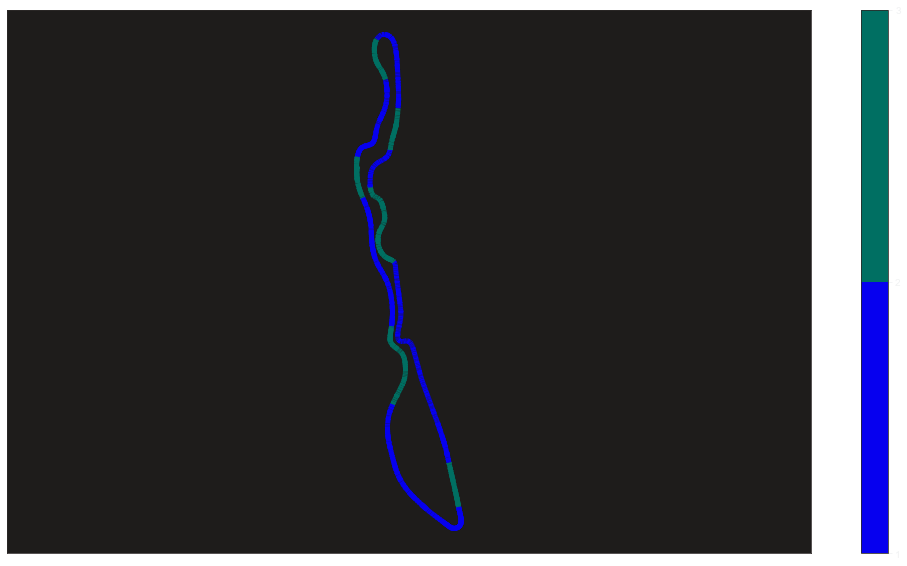

In [196]:
x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_driver_array = telemetry['Fastest_driver_int'].to_numpy().astype(float)

colors = [color1, color2]
cm = LinearSegmentedColormap.from_list(
        'newcm', colors, N=2)

lc_comp = LineCollection(segments, norm=plt.Normalize(1, cm.N+1), cmap=cm)
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(5)

plt.rcParams['figure.figsize'] = [18, 10]

plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1,4))
#cbar.set_ticks(np.arange(1.5, 4.5))
#cbar.set_ticklabels(['PER', 'LEC'])

plt.savefig(f"2023_PER_vs_ALO_q.png", dpi=300)

plt.show()